# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data/',                     # is the path where the train/test data is stored,
                       split='train',                 # specifies training or test dataset,
                       transform=transforms.Compose([ # specify the feature and label transformations
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [5]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [6]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [7]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if scheduler:
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch: {epoch}, Learning rate: {current_lr}')
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for x, y in loader:
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples
    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.819492, Train accuracy: 0.415708, Val accuracy: 0.558187
Average loss: 1.449506, Train accuracy: 0.589530, Val accuracy: 0.586035
Average loss: 1.376857, Train accuracy: 0.619766, Val accuracy: 0.618047


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [8]:
# Since it's so easy to add layers, let's add some!

nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.166150, Train accuracy: 0.213357, Val accuracy: 0.250563
Average loss: 1.943720, Train accuracy: 0.313603, Val accuracy: 0.367210
Average loss: 1.761371, Train accuracy: 0.401017, Val accuracy: 0.406662
Average loss: 1.698095, Train accuracy: 0.428881, Val accuracy: 0.424681
Average loss: 1.676661, Train accuracy: 0.440586, Val accuracy: 0.446727


Добавьте слой с Batch Normalization

In [9]:
# We heard batch normalization is powerful, let's use it!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.068041, Train accuracy: 0.308211, Val accuracy: 0.439560
Average loss: 1.759051, Train accuracy: 0.486196, Val accuracy: 0.535390
Average loss: 1.612658, Train accuracy: 0.556069, Val accuracy: 0.591905
Average loss: 1.520620, Train accuracy: 0.594069, Val accuracy: 0.613064
Average loss: 1.462534, Train accuracy: 0.615790, Val accuracy: 0.630537


Добавьте уменьшение скорости обучения по ходу тренировки.

In [14]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, 5, scheduler)

Epoch: 0, Learning rate: 0.001
Average loss: 2.041533, Train accuracy: 0.320035, Val accuracy: 0.443041
Epoch: 1, Learning rate: 0.0005
Average loss: 1.740675, Train accuracy: 0.483773, Val accuracy: 0.537711
Epoch: 2, Learning rate: 0.0005
Average loss: 1.623891, Train accuracy: 0.542572, Val accuracy: 0.571770
Epoch: 3, Learning rate: 0.00025
Average loss: 1.571284, Train accuracy: 0.568338, Val accuracy: 0.592451
Epoch: 4, Learning rate: 0.00025
Average loss: 1.534686, Train accuracy: 0.586851, Val accuracy: 0.610334


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [10]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    subsetsampler = SubsetSampler(val_indices)
    loader = torch.utils.data.DataLoader(data_train, batch_size=10, sampler=subsetsampler)
    
    predictions = torch.tensor([], dtype=torch.long)
    ground_truth = torch.tensor([], dtype=torch.long)

    for x, y in loader:
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        predictions = torch.cat((predictions, indices))
        ground_truth = torch.cat((ground_truth, y))
    
    return predictions.numpy(), ground_truth.numpy()

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

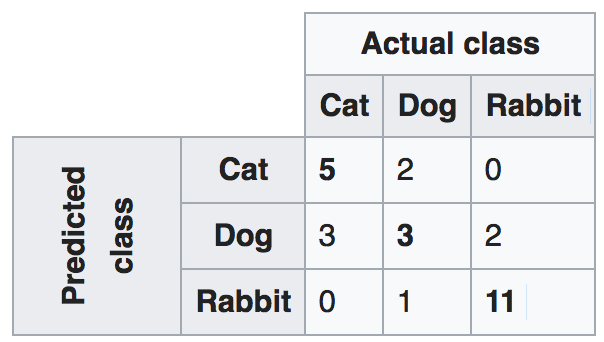

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

/tmp/ipykernel_15996/3090430893.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix = np.zeros((10,10), np.int)


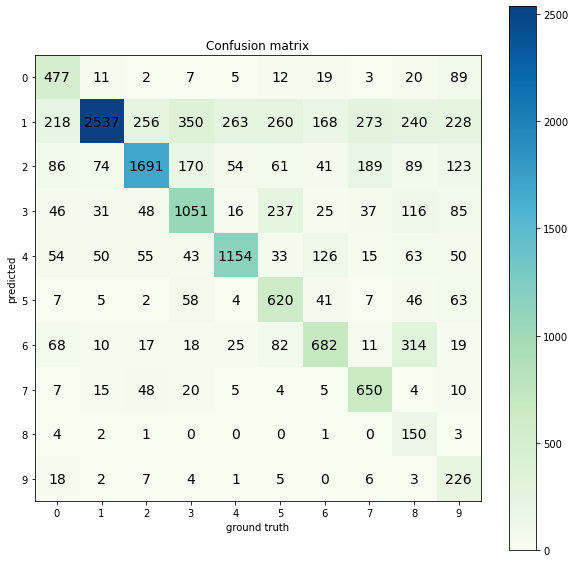

In [11]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    for k in range(len(predictions)):
        confusion_matrix[predictions[k]][ground_truth[k]] += 1
        
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

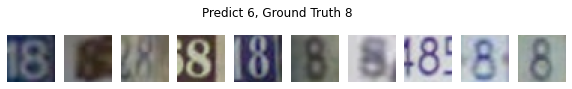

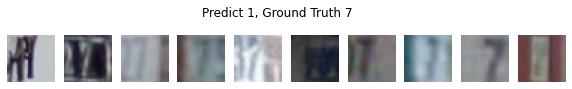

In [16]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    indices = np.array(val_indices)[(predictions == predicted_class)*(gt == gt_class)]
    visualize_images(indices, data, title=f'Predict {predicted_class}, Ground Truth {gt_class}')

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [36]:
# Experiment here!
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
num_epochs = 12
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),    
            nn.Linear(100, 10),
         )

optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

loss_history, train_history, val_history = train_model(nn_model,
                                                       train_loader,
                                                       val_loader,
                                                       loss,
                                                       optimizer,
                                                       num_epochs,
                                                       scheduler)

Epoch: 0, Learning rate: 0.001
Average loss: 1.330619, Train accuracy: 0.565932, Val accuracy: 0.689100
Epoch: 1, Learning rate: 0.001
Average loss: 0.908536, Train accuracy: 0.715473, Val accuracy: 0.733329
Epoch: 2, Learning rate: 0.001
Average loss: 0.788544, Train accuracy: 0.754121, Val accuracy: 0.757081
Epoch: 3, Learning rate: 0.0001
Average loss: 0.727541, Train accuracy: 0.770314, Val accuracy: 0.793393
Epoch: 4, Learning rate: 0.0001
Average loss: 0.557830, Train accuracy: 0.827748, Val accuracy: 0.832776
Epoch: 5, Learning rate: 0.0001
Average loss: 0.520314, Train accuracy: 0.840204, Val accuracy: 0.839124
Epoch: 6, Learning rate: 0.0001
Average loss: 0.500393, Train accuracy: 0.845579, Val accuracy: 0.840830
Epoch: 7, Learning rate: 1e-05
Average loss: 0.482153, Train accuracy: 0.851653, Val accuracy: 0.841171
Epoch: 8, Learning rate: 1e-05
Average loss: 0.454724, Train accuracy: 0.860134, Val accuracy: 0.846086
Epoch: 9, Learning rate: 1e-05
Average loss: 0.448914, Train

Test accuracy: 0.8218


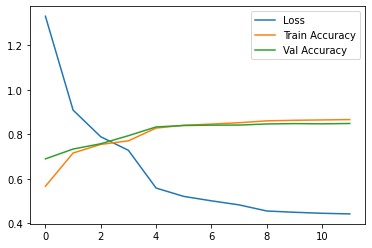

In [37]:
plt.plot(loss_history, label='Loss')
plt.plot(train_history, label='Train Accuracy')
plt.plot(val_history, label='Val Accuracy')
plt.legend()

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

In [34]:
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
num_epochs = 12
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),    
            nn.Linear(100, 10),
         )

optimizer = torch.optim.Adagrad(nn_model.parameters(), lr=1e-3, lr_decay=1e-5, weight_decay=1e-4)

loss_history, train_history, val_history = train_model(nn_model,
                                                       train_loader,
                                                       val_loader,
                                                       loss,
                                                       optimizer,
                                                       num_epochs)

Average loss: 1.332158, Train accuracy: 0.611695, Val accuracy: 0.718518
Average loss: 0.955921, Train accuracy: 0.727758, Val accuracy: 0.748277
Average loss: 0.835064, Train accuracy: 0.758028, Val accuracy: 0.770323
Average loss: 0.758564, Train accuracy: 0.778538, Val accuracy: 0.774213
Average loss: 0.702976, Train accuracy: 0.794151, Val accuracy: 0.794144
Average loss: 0.663150, Train accuracy: 0.806334, Val accuracy: 0.802607
Average loss: 0.628883, Train accuracy: 0.816128, Val accuracy: 0.804791
Average loss: 0.603738, Train accuracy: 0.822561, Val accuracy: 0.804723
Average loss: 0.579473, Train accuracy: 0.831502, Val accuracy: 0.815371
Average loss: 0.558103, Train accuracy: 0.836843, Val accuracy: 0.818033
Average loss: 0.541288, Train accuracy: 0.841842, Val accuracy: 0.820831
Average loss: 0.526648, Train accuracy: 0.845425, Val accuracy: 0.825814


Test accuracy: 0.8065


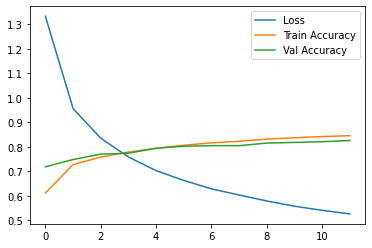

In [35]:
plt.plot(loss_history, label='Loss')
plt.plot(train_history, label='Train Accuracy')
plt.plot(val_history, label='Val Accuracy')
plt.legend()

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

In [ ]:
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
num_epochs = 12
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),    
            nn.Linear(100, 10),
         )

optimizer = torch.optim.RMSprop(nn_model.parameters(), lr=1e-3, alpha=0.9, weight_decay=1e-4, momentum=1e-5)

loss_history, train_history, val_history = train_model(nn_model,
                                                       train_loader,
                                                       val_loader,
                                                       loss,
                                                       optimizer,
                                                       num_epochs)

Average loss: 1.240713, Train accuracy: 0.600911, Val accuracy: 0.652379


Test accuracy: 0.7668


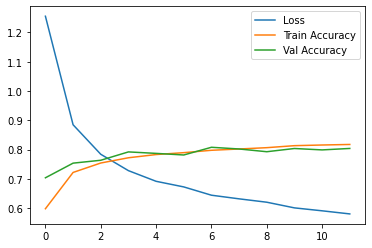

In [54]:
plt.plot(loss_history, label='Loss')
plt.plot(train_history, label='Train Accuracy')
plt.plot(val_history, label='Val Accuracy')
plt.legend()

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)